# Libraries

In [12]:
import torchvision
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn.modules.loss import _WeightedLoss
import torch.optim as optim
import torchvision.transforms as transforms

import PIL.Image as Image
import PIL.ImageOps as PIO
import PIL.ImageEnhance as PIE

import matplotlib.pyplot as plt


import numpy as np

import random
import time
from tqdm import tqdm
import os

# Global Configurations

In [13]:

cpc_path = os.path.join("TrainedModels", "trained_cpc")
encoder_path = os.path.join("TrainedModels", "trained_encoder")
colour = "_colour"
num_classes = 10
pred_steps = 3
neg_samples = 16
pred_directions = 1 # CPC2 feature 4
image_resize = 0
patch_aug = 1
num_workers = 1
crop='30-2'
crop_size = 30
padding = 2
grid_size = 5
norm = "" # CPC2 feature 'layer'
epochs = 20
sched_step_size = 100
print_interval = 1
print_option = 1
test_interval = 1

# Models

## Pixel CNN Model

This autoregressive model is used for Context generation

In [14]:

def same_padding(kernel_size):
    # assumming stride 1
    if isinstance(kernel_size, int):
        return kernel_size // 2
    else:
        return (kernel_size[0] // 2, kernel_size[1] // 2)

class MaskedConvolution2D(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size,
            *args, mask='B', vertical=False, mask_mode="noblind", **kwargs):
        if "padding" not in kwargs:
            assert "stride" not in kwargs
            kwargs["padding"] = same_padding(kernel_size)
        remove = {"conditional_features", "conditional_image_channels"}
        for feature in remove:
            if feature in kwargs:
                del kwargs[feature]
        super(MaskedConvolution2D, self).__init__(in_channels,
                out_channels, kernel_size, *args, **kwargs)
        Cout, Cin, kh, kw = self.weight.size()
        pre_mask = np.ones_like(self.weight.data.cpu().numpy()).astype(np.float32)
        yc, xc = kh // 2, kw // 2

        assert mask_mode in {"noblind", "turukin", "fig1-van-den-oord", "none", "only_vert"}

        if mask_mode == "none":
            pass
        elif mask_mode == "only_vert":
            pre_mask[:, :, yc + 1:, :] = 0.0
        elif mask_mode == "noblind":
            # context masking - subsequent pixels won't have access
            # to next pixels (spatial dim)
            if vertical:
                if mask == 'A':
                    # In the first layer, can ONLY access pixels above it
                    pre_mask[:, :, yc:, :] = 0.0
                else:
                    # In the second layer, can access pixels above or even with it.
                    pre_mask[:, :, yc+1:, :] = 0.0
            else:
                # All rows after center must be zero
                pre_mask[:, :, yc+1:, :] = 0.0
                # All columns after center in center row must be zero
                pre_mask[:, :, yc, xc+1:] = 0.0

            if mask == 'A':
                # Center must be zero in first layer
                pre_mask[:, :, yc, xc] = 0.0

        elif mask_mode == "fig1-van-den-oord":
            if vertical:
                pre_mask[:, :, yc:, :] = 0.0
            else:
                # All rows after center must be zero
                pre_mask[:, :, yc+1:, :] = 0.0
                # All columns after center in center row must be zero
                pre_mask[:, :, yc, xc+1:] = 0.0

            if mask == 'A':
                # Center must be zero in first layer
                pre_mask[:, :, yc, xc] = 0.0
        elif mask_mode == "turukin":
            pre_mask[:, :, yc+1:, :] = 0.0
            pre_mask[:, :, yc, xc+1:] = 0.0
            if mask == 'A':
                pre_mask[:, :, yc, xc] = 0.0

        #print("%s %s MASKED CONV: %d x %d. Mask:" % (mask, "VERTICAL" if vertical else "HORIZONTAL", kh, kw))
        #print(pre_mask[0, 0, :, :])

        self.register_buffer("mask", torch.from_numpy(pre_mask))

    def __call__(self, x):
        self.weight.data = self.weight.data * self.mask
        return super(MaskedConvolution2D, self).forward(x)


class PixelCNNGatedLayer(nn.Module):
    def __init__(self, primary, in_channels, out_channels, filter_size,
            mask='B', nobias=False, conditional_features=None,
            conditional_image_channels=None, residual_vertical=False,
            residual_horizontal=True, skips=False, gated=True,
            relu_out=False, horizontal_2d_convs=False, mask_mode="noblind", groups=1):
        super().__init__()
        self.primary = primary
        if primary:
            assert mask == 'A'
            assert not residual_vertical
            assert not residual_horizontal
        else:
            assert mask == 'B'
        self.out_channels = out_channels
        self.gated = gated
        gm = 2 if gated else 1
        self.vertical_conv = MaskedConvolution2D(
            in_channels, gm * out_channels, (filter_size, filter_size),
            mask=mask, vertical=True, mask_mode=mask_mode, groups=groups)
        self.v_to_h_conv = nn.Conv2d(gm * out_channels, gm * out_channels, 1, groups=groups)

        self.horizontal_conv = MaskedConvolution2D(
            in_channels, gm * out_channels,
            (filter_size if horizontal_2d_convs else 1, filter_size), # XXX: traditionally (1, filter_size),
            mask=mask, vertical=False, mask_mode=mask_mode, groups=groups)

        self.residual_vertical = None
        if residual_vertical:
            self.residual_vertical = nn.Conv2d(in_channels, gm * out_channels, 1, groups=groups)

        self.horizontal_output = nn.Conv2d(out_channels, out_channels, 1, groups=groups)
        self.horizontal_skip = None
        if skips:
            self.horizontal_skip = nn.Conv2d(out_channels, out_channels, 1, groups=groups)
        self.conditional_vector = conditional_features is not None
        self.conditional_image = conditional_image_channels is not None
        if self.conditional_image:
            self.cond_conv_h = nn.Conv2d(conditional_image_channels, gm * out_channels, 1, bias=False, groups=groups)
            self.cond_conv_v = nn.Conv2d(conditional_image_channels, gm * out_channels, 1, bias=False, groups=groups)
        if self.conditional_vector:
            self.cond_fc_h = nn.Linear(conditional_features, gm * out_channels, bias=False)
            self.cond_fc_v = nn.Linear(conditional_features, gm * out_channels, bias=False)
        self.residual_horizontal = residual_horizontal
        self.relu_out = relu_out

    @classmethod
    def primary(cls, in_channels, out_channels, filter_size,
            nobias=False, conditional_features=None,
            conditional_image_channels=None,
            skips=False, gated=True,
            relu_out=False, horizontal_2d_convs=False, mask_mode="noblind", groups=1):
        return cls(True, in_channels, out_channels, filter_size, nobias=nobias,
                mask='A', conditional_features=conditional_features,
                conditional_image_channels=conditional_image_channels,
                residual_vertical=False, residual_horizontal=False,
                skips=skips, gated=gated,
                relu_out=relu_out, horizontal_2d_convs=horizontal_2d_convs,
                mask_mode=mask_mode, groups=groups)

    @classmethod
    def secondary(cls, in_channels, out_channels, filter_size,
            nobias=False, conditional_features=None,
            conditional_image_channels=None, residual_vertical=True,
            residual_horizontal=True, skips=False, gated=True,
            relu_out=False, horizontal_2d_convs=False, mask_mode="noblind", groups=1):
        return cls(False, in_channels, out_channels, filter_size, nobias=nobias,
                mask='B', conditional_features=conditional_features,
                conditional_image_channels=conditional_image_channels,
                residual_vertical=residual_vertical, residual_horizontal=residual_horizontal,
                skips=skips, gated=gated, relu_out=relu_out,
                horizontal_2d_convs=horizontal_2d_convs, mask_mode=mask_mode, groups=groups)

    def _gate(self, x):
        if self.gated:
            return torch.tanh(x[:,:self.out_channels]) * torch.sigmoid(x[:,self.out_channels:])
        else:
            return x

    def __call__(self, v, h, conditional_image=None, conditional_vector=None):
        horizontal_preactivation = self.horizontal_conv(h) # 1xN
        vertical_preactivation = self.vertical_conv(v) # NxN
        v_to_h = self.v_to_h_conv(vertical_preactivation) # 1x1
        if self.residual_vertical is not None:
            vertical_preactivation = vertical_preactivation + self.residual_vertical(v) # 1x1 to residual
        horizontal_preactivation = horizontal_preactivation + v_to_h
        if self.conditional_image and conditional_image is not None:
            horizontal_preactivation = horizontal_preactivation + \
                    self.cond_conv_h(conditional_image)
            vertical_preactivation = vertical_preactivation + \
                    self.cond_conv_v(conditional_image)
        if self.conditional_vector and conditional_vector is not None:
            horizontal_preactivation = horizontal_preactivation + \
                    self.cond_fc_h(conditional_vector).unsqueeze(-1).unsqueeze(-1)
            vertical_preactivation = vertical_preactivation + \
                    self.cond_fc_v(conditional_vector).unsqueeze(-1).unsqueeze(-1)
        v_out = self._gate(vertical_preactivation)
        h_activated = self._gate(horizontal_preactivation)
        h_skip = None
        if self.horizontal_skip is not None:
            h_skip = self.horizontal_skip(h_activated)
        h_preres = self.horizontal_output(h_activated)
        if self.residual_horizontal:
            h_out = h + h_preres
        else:
            h_out = h_preres
        if self.relu_out:
            v_out = F.relu(v_out)
            h_out = F.relu(h_out)
            if h_skip is not None:
                h_skip = F.relu(h_skip)
        return v_out, h_out, h_skip


class PixelCNNGatedStack(nn.Module):
    def __init__(self, *args):
        super().__init__()
        layers = list(args)
        for i, layer in enumerate(layers):
            assert isinstance(layer, PixelCNNGatedLayer)
            if i == 0:
                assert layer.primary
            else:
                assert not layer.primary
        self.layers = nn.ModuleList(layers)

    def __call__(self, v, h, skips=None, conditional_image=None, conditional_vector=None):
        if skips is None:
            skips = []
        else:
            skips = [skips]
        for layer in self.layers:
            v, h, skip = layer(v, h, conditional_image=conditional_image, conditional_vector=conditional_vector)
            if skip is not None:
                skips.append(skip)
        if len(skips) == 0:
            skips = None
        else:
            skips = torch.cat(skips, 1)
        return v, h, skips

class PixelCNN(torch.nn.Module):
    def __init__(self, in_channels, pixelcnn_layers=4, **kwargs):
        super().__init__()

        layer_objs = [
            PixelCNNGatedLayer.primary(
                in_channels, in_channels, 3, mask_mode="only_vert", **kwargs
            )
        ]
        layer_objs = layer_objs + [
            PixelCNNGatedLayer.secondary(
                in_channels, in_channels, 3, mask_mode="only_vert", **kwargs
            )
            for _ in range(1, pixelcnn_layers)
        ]

        self.stack = PixelCNNGatedStack(*layer_objs)
        self.stack_out = nn.Conv2d(in_channels, in_channels, 1)

    def forward(self, input):
        _, c_out, _ = self.stack(input, input)  # Bc, C, H, W
        c_out = self.stack_out(c_out)

        assert c_out.shape[1] == input.shape[1]

        return c_out


## Encoder Models

models are modified to take input shapes like this: (batch_size, grid_size, grid_size, 3, patch_size, patch_size)

We take 5 x 5 grids of 10 x 10 patches from our 32 x 32 images

initial batch size is 32 so we end up with 800 10 x 10 image patches in each batch

When defining model if use_classifier is set to False, model outputs a representation tensor of (batch_size, grid_size, grid_size, encoding_size). encoding size is 512 in both models. if use_classifier is set to True, model reshapes representation to (batch_size, grid_size * grid_size, encoding_size) and averages all grids for each image, then passes through a linear classifier and outputs a tensor of (batch_size, 10)

All 4 blocks of Resnet18 are used.

Only the first 13 convolutional layers in VGG16 are used, because our patches are too small for a deeper network

In [15]:
####################### Resnet Model ########################################

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet18(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, stage = 4, use_classifier = True): # Stage
        super(ResNet18, self).__init__()
        self.in_planes = 64
        self.stage = 4
        self.use_classifier = use_classifier
        self.encoding_size = 512

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1) # Stride=1 for first layer
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        # Stage
        linear_in = [64, 128, 256, 512]
        self.linear = nn.Linear(linear_in[self.stage - 1] *block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):

        # Input x = (batch_size, grid_size, grid_size, channels, patch_size, patch_size)
        # Flatten to (batch_size * grid_size * grid_size, channels, patch_size, patch_size)
        x = x.view(
            x.shape[0] * x.shape[1] * x.shape[2], x.shape[3], x.shape[4], x.shape[5]
        )

        out = F.relu(self.bn1(self.conv1(x)))
        # Stage
        out = self.layer1(out)
        if self.stage > 1:
          out = self.layer2(out)
        if self.stage > 2:
          out = self.layer3(out)
        if self.stage > 3:
          out = self.layer4(out)
        # Stage
        #out = F.avg_pool2d(out, 64 // 2**self.stage) # Global average Pooling instead of MaxPool
        out = self.avgpool(out)
        out = out.view(-1, grid_size, grid_size, out.shape[1]) # (batch_size, grid_size, grid_size, encoding_size)

        # Use classifier if specified
        if self.use_classifier:

            # Reshape z to (batch_size, grid_size * grid_size, encoding_size)
            out = out.view(out.shape[0], grid_size * grid_size, self.encoding_size)
            # mean all patches for each image, z = (b, e)
            out = torch.mean(out, dim=1)
            out = self.linear(out)

        return out



############################## VGG model ##########################################



class VGG16(nn.Module):

    def __init__(self, use_classifier = True):
        super(VGG16, self).__init__()
        self.use_classifier = use_classifier
        self.encoding_size = 512

        # VGG16 model
        vgg = torchvision.models.vgg16(pretrained = False, num_classes=10)
        self.backbone = nn.Sequential(*list(vgg.children())[0][:23])
        self.linear = nn.Linear(self.encoding_size, num_classes)


    def forward(self, x):

      # Input x = (batch_size, grid_size, grid_size, channels, patch_size, patch_size)
      # Flatten to (batch_size * grid_size * grid_size, channels, patch_size, patch_size)
      x = x.view(
          x.shape[0] * x.shape[1] * x.shape[2], x.shape[3], x.shape[4], x.shape[5]
      )
      x = self.backbone(x)

      x = x.view(-1, grid_size, grid_size, x.shape[1]) # (batch_size, grid_size, grid_size, encoding_size)

      if self.use_classifier:
            # Reshape z to (batch_size, grid_size * grid_size, encoding_size)
            x = x.view(x.shape[0], grid_size * grid_size, self.encoding_size)
            # mean all patches for each image, z = (b, e)
            x = torch.mean(x, dim=1)
            x = self.linear(x)

      return x





########################## Testing models ########################################



#print('testing... resnet18 output size: ')
#net = ResNet18(BasicBlock, [2, 2, 2, 2], stage = 4, use_classifier = False)
#y = net(torch.randn(4, 5, 5, 3, 10, 10))
#print(y.size())

print('testing... VGG16 output size: ')
net = VGG16(use_classifier = True)
y = net(torch.randn(4, 5, 5, 3, 10, 10))
print(y.size())


testing... VGG16 output size: 
torch.Size([4, 10])


## CPC Model

This is the main model. It is created using Encoder and Pixel CNN models and uses InfoNCELoss

In [16]:

class CPC(nn.Module):
    """
    Args:
        encoderNet (nn.Module): instance of PyTorch model to be used for encoder network
        arNet (nn.Module): instance of PyTorch model to be used for autoregerssive (context) network
        pred_directions (int): number of directions to perform predictions
        pred_steps (int): number of steps into the future to perform predictions
        neg_samples (int): number of negative samples to be used for contrastive loss
    """

    def __init__(self, encoderNet, arNet, pred_directions, pred_steps, neg_samples):
        super().__init__()
        
        self.pred_directions = pred_directions
        assert 1 <= pred_directions <= 4

        # Define Encoder Network
        self.enc = encoderNet

        # Define Autoregressive Network
        self.ar = arNet

        # Define Predictive + Loss Networks
        self.pred_loss = nn.ModuleList(
            InfoNCE_Loss(pred_steps=pred_steps, neg_samples=neg_samples, in_channels=encoderNet.encoding_size)
            for _ in range(self.pred_directions)
        )

    def forward(self, x):
        # Input x = (batch_size, grid_size, grid_size, channels, patch_size, patch_size)

        # Find all encoding vectors
        self.encodings = self.enc(x) # (batch_size, grid_size, grid_size, encoding_size)

        # Permute encodings to (batch_size, encoding_size, grid_size, grid_size) for ar network
        self.encodings = self.encodings.permute(0,3,1,2).contiguous() # (batch_size, encoding_size, grid_size, grid_size)

        # For only 1 direction find context vectors and contrastive loss
        loss = 0
        for i in range(self.pred_directions): # Pred_directions = 1         this is a CPC2 feature
            # rotate encoding 90 degrees clockwise
            if i > 0:
                self.encodings = self.encodings.transpose(2,3).flip(3)

            # Find all context vectors
            self.contexts = self.ar(self.encodings) # (batch_size, encoding_size, grid_size, grid_size)

            # Find contrastive loss
            loss += self.pred_loss[i](self.encodings, self.contexts)
        loss /= self.pred_directions

        return loss


## InfoNCE Loss

Given Z (latent) and C (Context), this class calculates negative loglikelihood

16 negative samples are created for each image

In [17]:

class InfoNCE_Loss(nn.Module):
    """Performs predictions and InfoNCE Loss
    Args:
        pred_steps (int): number of steps into the future to perform predictions
        neg_samples (int): number of negative samples to be used for contrastive loss
        in_channels (int): number of channels of input tensors (size of encoding vector from encoder network and autoregressive network)
    """
    
    def __init__(self, pred_steps, neg_samples, in_channels):
        super().__init__()
        
        self.pred_steps = pred_steps
        self.neg_samples = neg_samples

        self.W_k = nn.ModuleList(
            nn.Conv2d(in_channels, in_channels, 1, bias=False)
            for _ in range(self.pred_steps)
        )

        self.contrast_loss = ExpNLLLoss()

    def forward(self, z, c, skip_step=1):
        batch_size = z.shape[0]
        total_loss = 0
        cur_device = z.get_device()

        # For each element in c, contrast with elements below
        for k in range(1, self.pred_steps + 1):
            ### compute log f(c_t, x_{t+k}) = z^T_{t+k} * W_k * c_t
            
            ### compute z^T_{t+k} * W_k:
            ztwk = (
                self.W_k[k - 1]
                .forward(z[:, :, (k + skip_step) :, :])  # Bx, C , H , W
                .permute(2, 3, 0, 1)  # H, W, Bx, C
                .contiguous()
            )  # y, x, b, c

            ztwk_shuf = ztwk.view(
                ztwk.shape[0] * ztwk.shape[1] * ztwk.shape[2], ztwk.shape[3]
            )  # y * x * batch, c
            rand_index = torch.randint(
                ztwk_shuf.shape[0],  # y *  x * batch
                (ztwk_shuf.shape[0] * self.neg_samples, 1),
                dtype=torch.long,
                device=cur_device,
            )
            # Sample more
            rand_index = rand_index.repeat(1, ztwk_shuf.shape[1])

            ztwk_shuf = torch.gather(
                ztwk_shuf, dim=0, index=rand_index, out=None
            )  # y * x * b * n, c

            ztwk_shuf = ztwk_shuf.view(
                ztwk.shape[0],
                ztwk.shape[1],
                ztwk.shape[2],
                self.neg_samples,
                ztwk.shape[3],
            ).permute(
                0, 1, 2, 4, 3
            )  # y, x, b, c, n

            ### Compute  x_W1 * c_t:
            context = (
                c[:, :, : -(k + skip_step), :].permute(2, 3, 0, 1).unsqueeze(-2)
            )  # y, x, b, 1, c

            log_fk_main = torch.matmul(context, ztwk.unsqueeze(-1)).squeeze(
                -2
            )  # y, x, b, 1

            log_fk_shuf = torch.matmul(context, ztwk_shuf).squeeze(-2)  # y, x, b, n

            log_fk = torch.cat((log_fk_main, log_fk_shuf), 3)  # y, x, b, 1+n
            log_fk = log_fk.permute(2, 3, 0, 1)  # b, 1+n, y, x

            log_fk = torch.softmax(log_fk, dim=1)

            true_f = torch.zeros(
                (batch_size, log_fk.shape[-2], log_fk.shape[-1]),
                dtype=torch.long,
                device=cur_device,
            )  # b, y, x

            total_loss += self.contrast_loss(input=log_fk, target=true_f)

        total_loss /= self.pred_steps

        return total_loss


class ExpNLLLoss(_WeightedLoss):

    def __init__(self, weight=None, size_average=None, ignore_index=-100,
                 reduce=None, reduction='mean'):
        super(ExpNLLLoss, self).__init__(weight, size_average, reduce, reduction)
        self.ignore_index = ignore_index

    def forward(self, input, target):
        x = torch.log(input + 1e-11)
        return F.nll_loss(x, target, weight=self.weight, ignore_index=self.ignore_index,
                          reduction=self.reduction)

# Data

## DataLoader

When creating unsupervised loader (self-supervised mode) all images are randomly cropped and resized, and are randomly horizontally flipped. When creating train and test loader (supervised mode), the images are only center cropped and resized.

Unsupervised loader: After image augmentation, images are patchified and proper transformations (exemplar or rotation) are applied

Train loader (supervised): Images are only patchfied.

Test loader (supervised): Images are only patchified.

In [18]:
aug = {
    "cifar10": {
        "mean": [0.49139968, 0.48215827, 0.44653124],
        "std": [0.24703233, 0.24348505, 0.26158768],
        "bw_mean": [0.4808616],
        "bw_std": [0.23919088],
    }
}

############ Do transformations given the mode ##############################
# This function applies transformations to the entire image, then creates augmented
# patch grids given the mode. 

def get_transforms(eval, aug, augment_mode='rotate'):
    trans = []
    
    # Crop full image
    if not eval:
        trans.append(transforms.RandomCrop(crop_size, padding))
    else:
        trans.append(transforms.CenterCrop(crop_size))

    # Resize image after cropping
    if image_resize:
        trans.append(transforms.Resize(image_resize))

    # Flip image
    if not eval:
        trans.append(transforms.RandomHorizontalFlip())

    trans.append(transforms.ToTensor())
    if eval or not patch_aug:
        trans.append(transforms.Normalize(mean=aug["mean"], std=aug["std"]))

    # If training CPC then patchify, if required also augment
    if not fully_supervised:
        if not eval and patch_aug:
            trans.append(PatchifyAugment(grid_size=grid_size))
        else:
            trans.append(Patchify(grid_size=grid_size))

    # If patch_aug then normalization goes last
    if not eval and patch_aug:
        trans.append(PatchAugNormalize(mean=aug["mean"], std=aug["std"]))

    trans = transforms.Compose(trans)

    s = "Testing" if eval else "Training"
    print(s + ": " + str(trans))

    return trans


############### Create unsupervised_loader, train_loader and test_loader ###########

def get_cifar10_dataloader():

    data_path = os.path.join("data", "cifar10")

    # Define Transforms
    transform_train = transforms.Compose(
        [get_transforms(eval=False, aug=aug["cifar10"])])
    transform_valid = transforms.Compose(
        [get_transforms(eval=True, aug=aug["cifar10"])])

    # Get Datasets
    unsupervised_dataset = torchvision.datasets.CIFAR10(
        data_path, train=True, transform=transform_train, download=True
    )
    test_dataset = torchvision.datasets.CIFAR10(
        data_path, train=False, transform=transform_valid, download=True
    )

    # Get DataLoaders
    unsupervised_loader = torch.utils.data.DataLoader(
        unsupervised_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers
    )
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers
    )

    # Take subset of training data for train_classifier
    #try:
    indices = list(range(len(unsupervised_dataset)))
    np.random.shuffle(indices)
    train_indices = indices[:train_size]
    train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)
    train_loader = torch.utils.data.DataLoader(
        unsupervised_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers,
    )
    #except:  
    #    # args.train_size is not defined during train_CPC
    #    # train_loader is not needed during train_CPC
    #    print('...')
    #    train_loader = None

    return (unsupervised_loader, train_loader, test_loader)



## Image Processing

Augmentation is done here

Original images are horizontally flipped, then image patches are augmented

augment_mode: rotate -> randomly a rotation from -30 to +30 degrees is applied

augment_mode: exemplar -> randomly choose 2 of these for each patch (shear + brightness(scaling) + contrast + color + rotation + invertion + translation + solarization ) and with 0.25 probability convert to grayscale

Original Exemplar augmentation is much simpler than the augmentations defined here; but these augmentations are nothing but a more complicated variation of the same augmentations used in the paper. the author of Exemplar paper encourages adding other similar augmentations especially ones that change and work with color.

In [19]:



class Patchify(object):     
    """Convert tensor image into grid of patches, where each path overlaps half of its neighbours

    Args:
        grid_size (int): defines the output grid size for the patchification
    """
    def __init__(self, grid_size):
        self.grid_size = grid_size
        self.patch_size = None

    def __call__(self, x):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be patchified.

        Returns:
            Tensor: Patchified Tensor image of shape (grid_size x grid_size x C x patch_size x patch_size)
        """

        # Calculate the size of the patches
        if self.patch_size is None:         
            # Patchifying requires a square input image
            if x.shape[1] != x.shape[2]:
                raise Exception("Patchifying requires a square input image")
            
            patch_size = float(x.shape[2] / (self.grid_size + 1) * 2)

            # Not all grid sizes are compatable, ensure that patch_size is a whole number
            if patch_size.is_integer():
                self.patch_size = int(patch_size)
            else:
                raise Exception("The specified grid size did not fit the image")

        # Input x = (channels, img_size, img_size)
        # Patchify to (grid_size, grid_size, channels, patch_size, patch_size)
        x = (
            x.unfold(1, self.patch_size, self.patch_size // 2)
            .unfold(2, self.patch_size, self.patch_size // 2)
            .permute(1, 2, 0, 3, 4)
            .contiguous()
        )

        return x

    def __repr__(self):
        return self.__class__.__name__ + '(grid_size={0})'.format(self.grid_size)


class PatchifyAugment(Patchify):
    """Convert tensor image into grid of patches, where each path overlaps half of its neighbours. 
    Then applies patch based augmentation.

    Args:
        gray (boolean): defines whether the input tensor is coloured or not
        grid_size (int): defines the output grid size for the patchification
    """

    def __init__(self, grid_size):
        super().__init__(grid_size=grid_size)
        self.gray = 0
        self.augment_mode = augment_mode
        # As labeled certain transformations have been written so that they
        # are applied on tensors, this alleviates the need to convert to PIL.Image

        self.transformations = [
            self.ShearX, # PIL
            self.ShearY, # PIL
            self.TranslateX, # Tensor
            self.TranslateY, # Tensor
            self.Rotate, # PIL
            PIO.autocontrast, # PIL 
            self.Invert, # Tensor
            PIO.equalize, # PIL 
            self.Solarize, # Tensor
            self.Posterize, # Tensor 
            self.Contrast, # PIL 
            self.Brightness, # PIL 
            self.Sharpness, # PIL 
            self.Cutout # Tensor
        ]
        if not self.gray:
            self.transformations.append(self.Color)

    def __call__(self, x):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be patchified and augmented.

        Returns:
            Tensor: Patchified and Augmented Tensor image of shape (grid_size x grid_size x C x patch_size x patch_size)
        """
        # Patchify using parent class
        x = super().__call__(x) 
        
        self.number_of_transforms = 2
        self.patch_dim = (self.patch_size, self.patch_size)
        
        # For each path apply augmentation as in CPC V2
        for patch_row in range(self.grid_size):
            for patch_col in range(self.grid_size):
                patch = x[patch_row][patch_col]
                
                if self.augment_mode == 'exemplar':
                  # Randomly choose two of the 16 (15 if grayscale) transformations from AutoAugment
                  for _ in range(self.number_of_transforms):
                      rand = random.randint(0, len(self.transformations)) 

                      # Tensor based functions - TranslateX/Y, Invert, Solarize, Posterize, Cutout
                      if rand == 2 or rand == 3 or rand == 6 or rand == 8 or rand == 9 or rand == 13 : 
                          transform = self.transformations[rand]
                          x[patch_row][patch_col] = transform(patch)

                      # Tensor based function - SamplePairing - requires two inputs
                      elif rand == len(self.transformations):
                          other_patch_row = random.randint(0, self.grid_size - 1)
                          other_patch_col = random.randint(0, self.grid_size - 1)
                          other_patch = x[other_patch_row][other_patch_col]

                          x[patch_row][patch_col] = self.SamplePairing(patch, other_patch)

                      # PIL functions
                      else:   
                          # Convert patch from tensor to PIL image
                          patch_PIL = transforms.ToPILImage()(patch)

                          # Choose transform from transformations array
                          transform = self.transformations[rand]
                          patch_PIL = transform(patch_PIL)

                          # Convert PIL back to tensor
                          x[patch_row][patch_col] = transforms.ToTensor()(patch_PIL)

                  # 4. Greyscale with 25% chance
                  if random.random() < 0.25:
                      patch_PIL = transforms.ToPILImage()(patch)
                      patch_PIL = transforms.Grayscale()(patch_PIL)
                      x[patch_row][patch_col] = transforms.ToTensor()(patch_PIL)

                elif self.augment_mode == 'rotate':
                    patch_PIL = transforms.ToPILImage()(patch)
                    transform = self.transformations[4]
                    patch_PIL = transform(patch_PIL)
                    x[patch_row][patch_col] = transforms.ToTensor()(patch_PIL)
        return x

    def __repr__(self):
        return self.__class__.__name__ + f'(grid_size={self.grid_size}, gray={self.gray})'

    # The following transformations either use PIL or are performed directly on Tensors
    def ShearX(self, pil_img):
        level = random.random() * 0.6 - 0.3  # [-0.3,0.3] As in AutoAugment
        return pil_img.transform(self.patch_dim, Image.AFFINE, (1, level, 0, 0, 1, 0))


    def ShearY(self, pil_img):
        level = random.random() * 0.6 - 0.3  # [-0.3,0.3] As in AutoAugment
        return pil_img.transform(self.patch_dim, Image.AFFINE, (1, 0, 0, level, 1, 0))


    def TranslateX(self, patch):
        # Autoaugment does [-150,150] pixels which is eqiuvalent to 45% of 331x331 image
        # 1/3 of patch - 45% seems excessive
        pixels = random.randint(int(-self.patch_size/3), int(self.patch_size/3))
        channels = patch.shape[0]

        # (C, H, W) - columns are dim 2
        if pixels < 0:
            patch = torch.cat((patch[:,:,-pixels:], torch.zeros(channels, self.patch_size, -pixels)), dim=2)
        elif pixels > 0:
            patch = torch.cat((torch.zeros(channels, self.patch_size, pixels), patch[:,:,:self.patch_size-pixels]), dim=2)

        return patch
        #return pil_img.transform(self.patch_dim, Image.AFFINE, (1, 0, pixels, 0, 1, 0))


    def TranslateY(self, patch):
        # Autoaugment does [-150,150] pixels which is eqiuvalent to ~1/2 of 331x331 image
        # 1/3 of patch - 45% seems excessive
        pixels = random.randint(int(-self.patch_size/3), int(self.patch_size/3))
        channels = patch.shape[0]

        # (C, H, W) - rows are dim 1
        if pixels < 0:
            patch = torch.cat((patch[:,-pixels:,:], torch.zeros(channels, -pixels, self.patch_size)), dim=1)
        elif pixels > 0:
            patch = torch.cat((torch.zeros(channels, pixels, self.patch_size), patch[:,:self.patch_size-pixels,:]), dim=1)

        return patch
        #return pil_img.transform(self.patch_dim, Image.AFFINE, (1, 0, pixels, 0, 1, 0))
        

    def Rotate(self, pil_img):
        degrees = random.random() * 60 - 30  # [-20, 20] as in AutoSegment
        return pil_img.rotate(degrees)


    def Invert(self, patch):
        return 1 - patch


    def Solarize(self, patch):
        threshold = random.random() # [0, 1) - equivalent to [0, 256] as in AutoSegment
        cond = patch >= threshold
        patch[cond] = 1 - patch[cond]
        return patch
        #threshold = random.randint(0, 256)  # [0, 256] as in AutoSegment
        #return PIO.solarize(pil_img, threshold)


    def Posterize(self, patch):
        bits = random.randint(4, 8)  # [4,8] as in AutoSegment
        patch = (patch * 255) // (2 ** (8 - bits)) * (2 ** (8-bits)) / 255
        return patch
        #return PIO.posterize(pil_img, bits)


    def Contrast(self, pil_img):
        level = random.random() * 1.8 + 0.1  # [0.1,1.9] As in AutoAugment
        return PIE.Contrast(pil_img).enhance(level)


    def Color(self, pil_img):
        level = random.random() * 1.8 + 0.1  # [0.1,1.9] As in AutoAugment
        return PIE.Color(pil_img).enhance(level)


    def Brightness(self, pil_img):
        level = random.random() * 1.8 + 0.1  # [0.1,1.9] As in AutoAugment
        return PIE.Brightness(pil_img).enhance(level)


    def Sharpness(self, pil_img):
        level = random.random() * 1.8 + 0.1  # [0.1,1.9] As in AutoAugment
        return PIE.Sharpness(pil_img).enhance(level)


    def Cutout(self, patch):
        # Autoaugment does [0, 60] pixels which is eqiuvalent to ~1/5th of 331x331 image
        # 1/3 of patch otherwise they are too small
        size = random.randint(1, int(self.patch_size/3))

        # generate top_left crop coordinate
        x_coord = random.randint(0, self.patch_size - size)
        y_coord = random.randint(0, self.patch_size - size)

        patch[:, x_coord:x_coord+size, y_coord:y_coord+size] = 0.5

        return patch


    def SamplePairing(self, patch, other_patch):
        level = random.random() * 0.4 # [0, 0.4] As in AutoAugment
        return patch + level * other_patch


class PrePatchAugNormalizeReshape(object):
    """
    Converts a tensor (grid_size x grid_size x C x patch_size x patch_size) to (C x  grid_size**2 x patch_size**2)
    """
    def __call__(self, img):
        # Move C to start
        img = img.permute(2, 0, 1, 3, 4)

        # Combine dimnensions
        img = img.view(img.shape[0], img.shape[1] * img.shape[2], img.shape[3] * img.shape[4]) 

        return img

    def __repr__(self):
        return self.__class__.__name__ + '()'


class PostPatchAugNormalizeReshape(object):
    """
    Converts a tensor (C x  grid_size**2 x patch_size**2) to (grid_size x grid_size x C x patch_size x patch_size)
    """
    def __call__(self, img):
        # Calcualte grid and patch size
        grid_size = int(img.shape[1] ** 0.5)
        patch_size = int(img.shape[2] ** 0.5)

        # Get rid of grid_size**2 and patch_size**2
        img = img.view(img.shape[0], grid_size, grid_size, patch_size, patch_size) 

        # Move C to dim 2
        img = img.permute(1, 2, 0, 3, 4)

        return img

    def __repr__(self):
        return self.__class__.__name__ + '()'


class PatchAugNormalize(object):
    """Normalize a tensor image with mean and standard deviation.
    Given the input shape of (grid_size x grid_size x C x patch_size x patch_size) 
    it performs reshaping before and after the normalization

    Args:
        mean (sequence): Sequence of means for each channel.
        std (sequence): Sequence of standard deviations for each channel.
    """
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, img):
        """
        Args:
            tensor (Tensor): Tensor image of size (grid_size x grid_size x C x patch_size x patch_size) to be normalized.

        Returns:
            Tensor: Normalized Tensor image.
        """
        img = PrePatchAugNormalizeReshape()(img)
        img = transforms.Normalize(mean=self.mean, std=self.std)(img)
        img = PostPatchAugNormalizeReshape()(img)
        return img

    def __repr__(self):
        return self.__class__.__name__ + f'(mean={self.mean}, std={self.std})'

# Self-Supervised CPC Training Functions

In [20]:

################### Main self-supervised training function ################################

def train():

  try:
    iter_per_epoch = len(unsupervised_loader)
    epoch_loss_batches = round(0.9 * iter_per_epoch)

    for epoch in range(trained_epochs+1, trained_epochs+epochs+1):
        prev_time = time.time()
        epoch_loss = 0

        for i, (batch, _) in enumerate(tqdm(unsupervised_loader, disable=print_option, dynamic_ncols=True)):       
            net.zero_grad()
            loss = net(batch.to('cuda'))
            loss.backward()
            optimizer.step()

            # Total loss of last 10% of batches
            if i >= epoch_loss_batches:
                epoch_loss += float(loss)

            if (((i+1) % (iter_per_epoch//10)) == 0 or i == 0) and print_option == 1:
                if i == 0:
                    div = 1
                elif i+1 == print_interval:
                    div = print_interval - 1
                else:
                    div = print_interval

                avg_time = (time.time() - prev_time) / div
                prev_time = time.time()

                # Print interval statistics
                print(
                    'Epoch {}/{}, Iteration {}/{}, Loss: {:.4f}, Time(s): {:.2f}'.format(
                        epoch,
                        trained_epochs + epochs,
                        i+1,
                        iter_per_epoch,
                        loss,
                        avg_time
                    )
                )

        # Results at end of epoch
        print(
            'Epoch {}/{}, Epoch Loss: {:.4f}'.format(
                epoch,
                trained_epochs + epochs,
                epoch_loss/(iter_per_epoch-epoch_loss_batches),
            )
        )

        # Save net at every epoch
        save_to_checkpoint(net, optimizer, epoch_loss/(iter_per_epoch-epoch_loss_batches), epoch)


  except KeyboardInterrupt:
    print("\nEnding Program on Keyboard Interrupt")



################################# Checkpoint ##################################

def save_to_checkpoint(net, optimizer, loss, epoch):
    print('Saving..')
    state = {
        'model': net.state_dict(),
        'optimizer': optimizer.state_dict(),
        'loss': loss,
        'epoch': epoch
    }
    if not os.path.isdir(checkpoint_dir):
        os.mkdir(checkpoint_dir)
    torch.save(state, checkpoint_dir + 'ckpt.pth')


def load_from_checkpoint():
    #try:
      print('==> Resuming from checkpoint..')
      checkpoint = torch.load(checkpoint_dir + 'ckpt.pth')
      net.load_state_dict(checkpoint['model'])
      optimizer.load_state_dict(checkpoint['optimizer'])
      loss = checkpoint['loss']
      epoch = checkpoint['epoch'] 

      print('recovered loss and epoch:')
      print(loss)
      print(epoch)

    #except:
     # a = input('no checkpoint detected... start from beginning? (y/n)')
    #  if a == 'n':
     #   exit()

################################ Show image grid #########################################

def imshow(img):
    img = img.cpu()
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()



# Supervised CPC Classifier Training Functions

In [21]:

# Process a batch, return accuracy and loss
def fwd_pass(x, y, train=False):
    
    # Run the network
    if train:
        net.zero_grad()
        net.train()
        outputs = net(x)

    else:
        net.eval()
        with torch.no_grad():
            outputs = net(x)

    # Compute accuracy
    matches = [torch.argmax(i) == j for i, j in zip(outputs, y)]
    acc = matches.count(True)/len(matches)

    # Compute loss
    loss = loss_function(outputs, y)

    if train:
        loss.backward()
        optimizer.step()

    return loss, acc


def train_classifier():
    best_acc = 0
    best_epoch = 0
    for epoch in range(1, epochs+1):
        epoch_loss = 0
        epoch_acc = 0

        for batch_img, batch_lbl in tqdm(train_loader, dynamic_ncols=True):
            loss, acc = fwd_pass(batch_img.to('cuda'), batch_lbl.to('cuda'), train=True)
            epoch_loss += loss
            epoch_acc += acc

        epoch_loss /= len(train_loader)
        epoch_acc /= len(train_loader)

        # Get learning rate
        lr = round(optimizer.param_groups[0]['lr'], 10)
        
        #test the performance
        test_loss, test_acc = test()

        if test_acc > best_acc:
            best_acc = test_acc
            best_epoch = epoch
            
        print(f"Epoch: {epoch}/{epochs} (lr={lr})\n"
              f"Train: {epoch_loss:.4f}, {epoch_acc*100:.2f}%\n"
              f"Test:  {test_loss:.4f}, {test_acc*100:.2f}%")

    print(f"Best Accuracy: {best_acc*100:.2f} - epoch {best_epoch}")


def test():
    total_test_acc = 0
    total_test_loss = 0

    for batch_img, batch_lbl in tqdm(test_loader, dynamic_ncols=True):
        loss, acc = fwd_pass(batch_img.to('cuda'), batch_lbl.to('cuda'), train=False)
        total_test_acc += acc
        total_test_loss += loss

    return total_test_loss / len(test_loader), total_test_acc / len(test_loader)


# Resnet18 Exemplar

## Self-Supervised

### Config

batch_size = 32

augment_mode = exemplar

encoder_model = resnet18

In [22]:
checkpoint_dir = './drive/MyDrive/ADL/3_3/resnet_checkpoint_exemplar/'
augment_mode = 'exemplar'
encoder_model = "resnet18"
trained_epochs = 0

train_size = None
fully_supervised = 0 

batch_size = 32 
lr = 2e-4

### Load Model

In [24]:

# Define Encoder Network
if encoder_model == "resnet18":
  enc = ResNet18(BasicBlock, [2, 2, 2, 2], use_classifier=False)
elif encoder_model == "vgg":
  enc = VGG16(use_classifier=False)
    
# Define Autrogressive Network
ar = PixelCNN(in_channels=enc.encoding_size)

# Define CPC Network
net = CPC(enc, ar, pred_directions, pred_steps, neg_samples)
net = net.to('cuda')


# Freeze classifier layer - save memory
for name, param in net.named_parameters():
    if ("linear" in name) or ('classifier' in name):
        param.requires_grad = False

optimizer = optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=lr)

if trained_epochs != 0: # Load from checkpoint
  load_from_checkpoint()
  net.train()

### Load data

grid patches of an image after Exemplar augmentation are shown below

Training: Compose(
    RandomCrop(size=(30, 30), padding=2)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    PatchifyAugment(grid_size=5, gray=0)
    PatchAugNormalize(mean=[0.49139968, 0.48215827, 0.44653124], std=[0.24703233, 0.24348505, 0.26158768])
)
Testing: Compose(
    CenterCrop(size=(30, 30))
    ToTensor()
    Normalize(mean=[0.49139968, 0.48215827, 0.44653124], std=[0.24703233, 0.24348505, 0.26158768])
    Patchify(grid_size=5)
)
Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 5, 5, 3, 10, 10])
torch.Size([32])


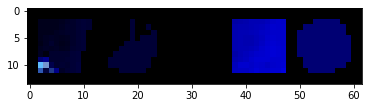

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


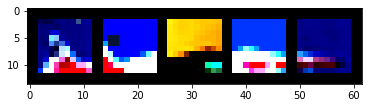

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


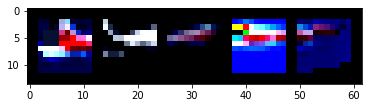

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


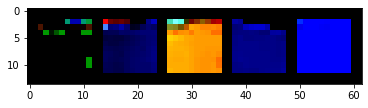

In [26]:
# Get selected dataset

unsupervised_loader, _, _ = get_cifar10_dataloader()

# Test it
s = iter(unsupervised_loader)
x, y = s.next()

print(x.size())
print(y.size())

for i in range(4):
  imshow(torchvision.utils.make_grid(x[0, i]))

### Train

Epoch 6/20, Epoch Loss: 1.4041

In [ ]:
# Train the network
print(f"Encoder: {encoder_model}, Crop: {crop}, Grid Size: {grid_size}, Norm: {norm}, Pred Directions: {pred_directions}, Patch Aug: {patch_aug}")

train()

Encoder: resnet18, Crop: 30-2, Grid Size: 5, Norm: , Pred Directions: 1, Patch Aug: 1
Epoch 1/20, Iteration 1/1563, Loss: 2.0579, Time(s): 0.46
Epoch 1/20, Iteration 156/1563, Loss: 2.0022, Time(s): 54.66
Epoch 1/20, Iteration 312/1563, Loss: 2.1393, Time(s): 54.00
Epoch 1/20, Iteration 468/1563, Loss: 1.9058, Time(s): 54.21
Epoch 1/20, Iteration 624/1563, Loss: 1.9490, Time(s): 54.13
Epoch 1/20, Iteration 780/1563, Loss: 1.9915, Time(s): 54.23
Epoch 1/20, Iteration 936/1563, Loss: 1.9083, Time(s): 54.21
Epoch 1/20, Iteration 1092/1563, Loss: 1.8893, Time(s): 54.22
Epoch 1/20, Iteration 1248/1563, Loss: 1.9479, Time(s): 54.20
Epoch 1/20, Iteration 1404/1563, Loss: 1.9258, Time(s): 54.22
Epoch 1/20, Iteration 1560/1563, Loss: 1.7075, Time(s): 54.82
Epoch 1/20, Epoch Loss: 1.8951
Saving..
Epoch 2/20, Iteration 1/1563, Loss: 1.7522, Time(s): 0.49
Epoch 2/20, Iteration 156/1563, Loss: 1.8353, Time(s): 53.82
Epoch 2/20, Iteration 312/1563, Loss: 1.9856, Time(s): 54.10
Epoch 2/20, Iteration 

## Supervised

### Config

no patch augmentation is done

In [ ]:
checkpoint_dir = './drive/MyDrive/ADL/3_3/resnet_checkpoint_exemplar/'
encoder_model = 'resnet18'
augment_mode = 'exemplar'
train_size = 10000 
batch_size = 100

fully_supervised = 0 #WTF is it gonna be man
cpc_patch_aug = 1 
patch_aug = 0
lr = 0.1 
lr_gamma = 0.1 #Scheduler

### Load data

grid patches of an image without any augmentation are shown below

Training: Compose(
    RandomCrop(size=(30, 30), padding=2)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=[0.49139968, 0.48215827, 0.44653124], std=[0.24703233, 0.24348505, 0.26158768])
    Patchify(grid_size=5)
)
Testing: Compose(
    CenterCrop(size=(30, 30))
    ToTensor()
    Normalize(mean=[0.49139968, 0.48215827, 0.44653124], std=[0.24703233, 0.24348505, 0.26158768])
    Patchify(grid_size=5)
)
Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([100, 5, 5, 3, 10, 10])
torch.Size([100])


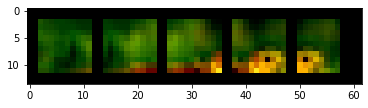

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


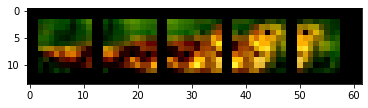

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


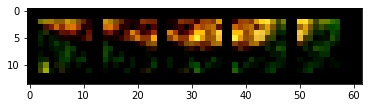

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


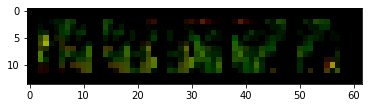

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([100, 5, 5, 3, 10, 10])
torch.Size([100])


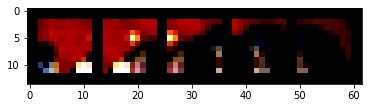

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


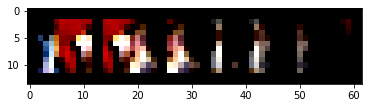

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


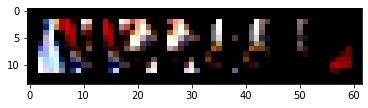

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


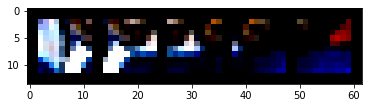

In [ ]:
_, train_loader, test_loader = get_cifar10_dataloader()

# Test it

s = iter(train_loader)

x, y = s.next()
print(x.size())
print(y.size())
for i in range(4):
  imshow(torchvision.utils.make_grid(x[0, i]))

# Test it
s = iter(test_loader)
x, y = s.next()
print(x.size())
print(y.size())
for i in range(4):
  imshow(torchvision.utils.make_grid(x[0, i]))


### Train

Best Accuracy: 58.94 - epoch 17

In [ ]:

print("Training CPC Classifier")

# Load the CPC trained encoder (with classifier layer activated)
if encoder_model == "resnet18":
    net = ResNet18(BasicBlock, [2, 2, 2, 2], use_classifier=True)
elif encoder_model == "vgg16":
    net = VGG16(use_classifier=True)
net = net.to('cuda')

# Load from checkpoint
print('==> Resuming from checkpoint..')
checkpoint = torch.load(checkpoint_dir + 'ckpt.pth')
# Remove "enc" prefix in model keys()
checkpoint['model'] = {k[4:]: v for k, v in checkpoint['model'].items() if 'enc' in k}
net.load_state_dict(checkpoint['model'])
loss = checkpoint['loss']
epoch = checkpoint['epoch'] 
print('recovered loss and epoch:')
print(loss)
print(epoch)


# Freeze encoder layers
for name, param in net.named_parameters():
    if ("classifier" not in name) and ("linear" not in name):
        param.requires_grad = False
    else:
        param.requires_grad = True

optimizer = optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=lr)


# define scheduler based on argument inputs
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=lr_gamma)

loss_function = nn.CrossEntropyLoss()

try:
    train_classifier()
except KeyboardInterrupt:
    print("\nEnding Program on Keyboard Interrupt")


Training CPC Classifier
==> Resuming from checkpoint..


  0%|          | 0/100 [00:00<?, ?it/s]

recovered loss and epoch:
1.404101549814909
6


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1/20 (lr=0.1)
Train: 11.3099, 32.22%
Test:  1.7757, 46.15%


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 2/20 (lr=0.1)
Train: 1.7612, 46.52%
Test:  1.7807, 50.68%


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 3/20 (lr=0.1)
Train: 2.1271, 45.12%
Test:  1.5271, 50.90%


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 4/20 (lr=0.1)
Train: 2.1935, 44.73%
Test:  2.3755, 44.60%


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 5/20 (lr=0.1)
Train: 2.2980, 45.50%
Test:  2.0419, 46.45%


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 6/20 (lr=0.1)
Train: 1.8697, 49.07%
Test:  1.9041, 50.98%


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 7/20 (lr=0.1)
Train: 1.9507, 49.28%
Test:  1.6562, 53.11%


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 8/20 (lr=0.1)
Train: 2.5271, 46.53%
Test:  2.1089, 52.46%


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 9/20 (lr=0.1)
Train: 2.1270, 50.01%
Test:  1.6373, 53.55%


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 10/20 (lr=0.1)
Train: 2.1270, 48.94%
Test:  2.2478, 46.33%


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 11/20 (lr=0.1)
Train: 1.9051, 51.13%
Test:  2.4749, 46.79%


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 12/20 (lr=0.1)
Train: 1.9826, 50.40%
Test:  1.8814, 49.91%


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 13/20 (lr=0.1)
Train: 2.0941, 49.99%
Test:  2.1555, 48.06%


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 14/20 (lr=0.1)
Train: 2.0789, 50.76%
Test:  2.0675, 48.39%


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 15/20 (lr=0.1)
Train: 2.2098, 48.87%
Test:  1.9680, 52.17%


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 16/20 (lr=0.1)
Train: 2.0774, 51.44%
Test:  1.7888, 54.04%


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 17/20 (lr=0.1)
Train: 1.9802, 52.10%
Test:  1.4406, 58.94%


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 18/20 (lr=0.1)
Train: 2.2032, 50.53%
Test:  2.0993, 54.12%


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 19/20 (lr=0.1)
Train: 1.8890, 52.63%
Test:  1.7698, 55.07%


100%|██████████| 100/100 [00:15<00:00,  6.39it/s]

Epoch: 20/20 (lr=0.1)
Train: 1.9093, 52.55%
Test:  2.4832, 53.51%
Best Accuracy: 58.94 - epoch 17


# Resnet18 Rotate

## Self-Supervised

### Config

augment_mode = rotate

encoder_model = resnet18

In [ ]:
checkpoint_dir = './drive/MyDrive/ADL/3_3/resnet_checkpoint_rotate/'
augment_mode = 'rotate'
encoder_model = "resnet18"
trained_epochs = 0

train_size = None
fully_supervised = 0 
patch_aug = 1

batch_size = 32 
lr = 2e-4

### Model

In [ ]:

# Define Encoder Network
if encoder_model == "resnet18":
  enc = ResNet18(BasicBlock, [2, 2, 2, 2], use_classifier=False)
elif encoder_model == "vgg":
  enc = VGG16(use_classifier=False)
    
# Define Autrogressive Network
ar = PixelCNN(in_channels=enc.encoding_size)

# Define CPC Network
net = CPC(enc, ar, pred_directions, pred_steps, neg_samples)
net = net.to('cuda')


# Freeze classifier layer - save memory
for name, param in net.named_parameters():
    if ("linear" in name) or ('classifier' in name):
        param.requires_grad = False

optimizer = optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=lr)

if trained_epochs != 0: # Load from checkpoint
  load_from_checkpoint()
  net.train()

### Load data

grid patches of an image after Rotation augmentation are shown below

Training: Compose(
    RandomCrop(size=(30, 30), padding=2)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    PatchifyAugment(grid_size=5, gray=0)
    PatchAugNormalize(mean=[0.49139968, 0.48215827, 0.44653124], std=[0.24703233, 0.24348505, 0.26158768])
)
Testing: Compose(
    CenterCrop(size=(30, 30))
    ToTensor()
    Normalize(mean=[0.49139968, 0.48215827, 0.44653124], std=[0.24703233, 0.24348505, 0.26158768])
    Patchify(grid_size=5)
)
Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 5, 5, 3, 10, 10])
torch.Size([32])


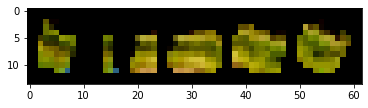

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


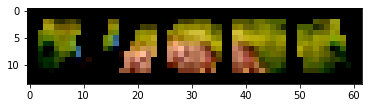

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


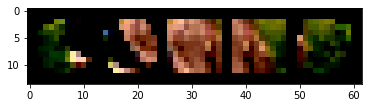

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


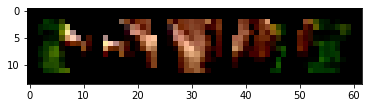

In [ ]:
# Get selected dataset

unsupervised_loader, _, _ = get_cifar10_dataloader()

# Test it
s = iter(unsupervised_loader)
x, y = s.next()

print(x.size())
print(y.size())

for i in range(4):
  imshow(torchvision.utils.make_grid(x[0, i]))

### Train

Epoch 6/20, Epoch Loss: 0.7079

Recognizing Rotation is a much easier task than recognizing Exemplar

In [ ]:
# Train the network
print(f"Encoder: {encoder_model}, Crop: {crop}, Grid Size: {grid_size}, Norm: {norm}, Pred Directions: {pred_directions}, Patch Aug: {patch_aug}")

train()

Encoder: resnet18, Crop: 30-2, Grid Size: 5, Norm: , Pred Directions: 1, Patch Aug: 1
Epoch 1/20, Iteration 1/1563, Loss: 0.9268, Time(s): 0.36
Epoch 1/20, Iteration 156/1563, Loss: 0.9799, Time(s): 54.61
Epoch 1/20, Iteration 312/1563, Loss: 1.0846, Time(s): 54.01
Epoch 1/20, Iteration 468/1563, Loss: 0.8161, Time(s): 54.39
Epoch 1/20, Iteration 624/1563, Loss: 0.7725, Time(s): 54.18
Epoch 1/20, Iteration 780/1563, Loss: 0.8851, Time(s): 54.25
Epoch 1/20, Iteration 936/1563, Loss: 0.9007, Time(s): 54.26
Epoch 1/20, Iteration 1092/1563, Loss: 0.8430, Time(s): 54.19
Epoch 1/20, Iteration 1248/1563, Loss: 0.9488, Time(s): 54.25
Epoch 1/20, Iteration 1404/1563, Loss: 0.7560, Time(s): 54.33
Epoch 1/20, Iteration 1560/1563, Loss: 0.9682, Time(s): 54.98
Epoch 1/20, Epoch Loss: 0.9166
Saving..
Epoch 2/20, Iteration 1/1563, Loss: 0.9607, Time(s): 0.39
Epoch 2/20, Iteration 156/1563, Loss: 0.8999, Time(s): 53.94
Epoch 2/20, Iteration 312/1563, Loss: 0.8551, Time(s): 54.19
Epoch 2/20, Iteration 

## Supervised

### Config

In [ ]:
checkpoint_dir = './drive/MyDrive/ADL/3_3/resnet_checkpoint_rotate/'
encoder_model = 'resnet18'
augment_mode = 'rotate'
train_size = 10000 
batch_size = 100

fully_supervised = 0 #WTF is it gonna be man
cpc_patch_aug = 1 
patch_aug = 0
lr = 0.1 
lr_gamma = 0.1 #Scheduler

### Load data

Training: Compose(
    RandomCrop(size=(30, 30), padding=2)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=[0.49139968, 0.48215827, 0.44653124], std=[0.24703233, 0.24348505, 0.26158768])
    Patchify(grid_size=5)
)
Testing: Compose(
    CenterCrop(size=(30, 30))
    ToTensor()
    Normalize(mean=[0.49139968, 0.48215827, 0.44653124], std=[0.24703233, 0.24348505, 0.26158768])
    Patchify(grid_size=5)
)
Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([100, 5, 5, 3, 10, 10])
torch.Size([100])


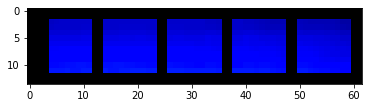

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


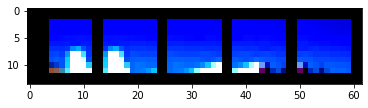

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


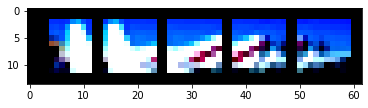

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


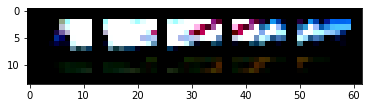

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([100, 5, 5, 3, 10, 10])
torch.Size([100])


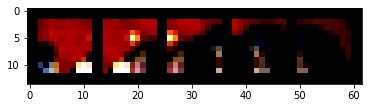

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


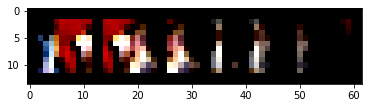

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


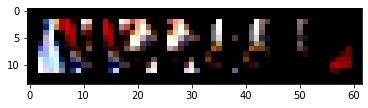

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


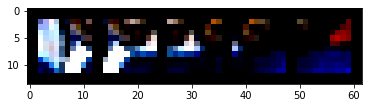

In [ ]:
_, train_loader, test_loader = get_cifar10_dataloader()

# Test it

s = iter(train_loader)

x, y = s.next()
print(x.size())
print(y.size())
for i in range(4):
  imshow(torchvision.utils.make_grid(x[0, i]))

# Test it
s = iter(test_loader)
x, y = s.next()
print(x.size())
print(y.size())
for i in range(4):
  imshow(torchvision.utils.make_grid(x[0, i]))


### Train

Best Accuracy: 54.73 - epoch 14

Exemplar did better

In [ ]:

print("Training CPC Classifier")

# Load the CPC trained encoder (with classifier layer activated)
if encoder_model == "resnet18":
    net = ResNet18(BasicBlock, [2, 2, 2, 2], use_classifier=True)
elif encoder_model == "vgg16":
    net = VGG16(use_classifier=True)
net = net.to('cuda')

# Load from checkpoint
print('==> Resuming from checkpoint..')
checkpoint = torch.load(checkpoint_dir + 'ckpt.pth')
# Remove "enc" prefix in model keys()
checkpoint['model'] = {k[4:]: v for k, v in checkpoint['model'].items() if 'enc' in k}
net.load_state_dict(checkpoint['model'])
loss = checkpoint['loss']
epoch = checkpoint['epoch'] 
print('recovered loss and epoch:')
print(loss)
print(epoch)


# Freeze encoder layers
for name, param in net.named_parameters():
    if ("classifier" not in name) and ("linear" not in name):
        param.requires_grad = False
    else:
        param.requires_grad = True

optimizer = optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=lr)


# define scheduler based on argument inputs
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=lr_gamma)

loss_function = nn.CrossEntropyLoss()

try:
    train_classifier()
except KeyboardInterrupt:
    print("\nEnding Program on Keyboard Interrupt")


Training CPC Classifier
==> Resuming from checkpoint..


  0%|          | 0/100 [00:00<?, ?it/s]

recovered loss and epoch:
0.7078680304380564
6


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1/20 (lr=0.1)
Train: 3.2330, 33.65%
Test:  1.6637, 43.95%


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 2/20 (lr=0.1)
Train: 1.6739, 43.42%
Test:  1.5949, 45.64%


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 3/20 (lr=0.1)
Train: 1.5912, 46.43%
Test:  1.4520, 49.36%


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 4/20 (lr=0.1)
Train: 1.7130, 45.49%
Test:  2.0304, 44.48%


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 5/20 (lr=0.1)
Train: 1.6562, 45.62%
Test:  1.4935, 49.68%


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 6/20 (lr=0.1)
Train: 1.6478, 46.65%
Test:  1.6638, 46.50%


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 7/20 (lr=0.1)
Train: 1.6980, 46.72%
Test:  1.6474, 48.27%


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 8/20 (lr=0.1)
Train: 1.6048, 48.50%
Test:  1.5274, 49.54%


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 9/20 (lr=0.1)
Train: 1.6041, 48.47%
Test:  1.5506, 47.44%


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 10/20 (lr=0.1)
Train: 1.6480, 47.87%
Test:  1.7736, 48.34%


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 11/20 (lr=0.1)
Train: 1.6354, 48.33%
Test:  1.9728, 45.10%


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 12/20 (lr=0.1)
Train: 1.5793, 49.95%
Test:  1.6046, 49.32%


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 13/20 (lr=0.1)
Train: 1.6293, 49.56%
Test:  1.4644, 52.45%


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 14/20 (lr=0.1)
Train: 1.5305, 50.12%
Test:  1.3531, 54.73%


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 15/20 (lr=0.1)
Train: 1.5621, 50.94%
Test:  2.0038, 41.42%


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 16/20 (lr=0.1)
Train: 1.5371, 50.40%
Test:  1.6014, 48.87%


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 17/20 (lr=0.1)
Train: 1.5591, 49.90%
Test:  1.5494, 50.78%


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 18/20 (lr=0.1)
Train: 1.6463, 49.43%
Test:  1.6290, 50.77%


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 19/20 (lr=0.1)
Train: 1.6902, 49.29%
Test:  1.5924, 51.21%


100%|██████████| 100/100 [00:15<00:00,  6.38it/s]

Epoch: 20/20 (lr=0.1)
Train: 1.6171, 50.23%
Test:  1.7861, 48.00%
Best Accuracy: 54.73 - epoch 14


# VGG16 Exemplar

## Self-Supervised

### Config

augment_mode = exemplar

encoder_model = vgg16

In [ ]:
checkpoint_dir = './drive/MyDrive/ADL/3_3/vgg_checkpoint_exemplar/'
augment_mode = 'exemplar'
encoder_model = "vgg16"
trained_epochs = 0

train_size = None
fully_supervised = 0 
patch_aug = 1

batch_size = 32 
lr = 2e-4

### Model

In [ ]:

# Define Encoder Network
if encoder_model == "resnet18":
  enc = ResNet18(BasicBlock, [2, 2, 2, 2], use_classifier=False)
elif encoder_model == "vgg16":
  enc = VGG16(use_classifier=False)
    
# Define Autrogressive Network
ar = PixelCNN(in_channels=enc.encoding_size)

# Define CPC Network
net = CPC(enc, ar, pred_directions, pred_steps, neg_samples)
net = net.to('cuda')


# Freeze classifier layer - save memory
for name, param in net.named_parameters():
    if ("linear" in name) or ('classifier' in name):
        param.requires_grad = False

optimizer = optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=lr)

if trained_epochs != 0: # Load from checkpoint
  load_from_checkpoint()
  net.train()

### Load data

Training: Compose(
    RandomCrop(size=(30, 30), padding=2)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    PatchifyAugment(grid_size=5, gray=0)
    PatchAugNormalize(mean=[0.49139968, 0.48215827, 0.44653124], std=[0.24703233, 0.24348505, 0.26158768])
)
Testing: Compose(
    CenterCrop(size=(30, 30))
    ToTensor()
    Normalize(mean=[0.49139968, 0.48215827, 0.44653124], std=[0.24703233, 0.24348505, 0.26158768])
    Patchify(grid_size=5)
)
Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 5, 5, 3, 10, 10])
torch.Size([32])


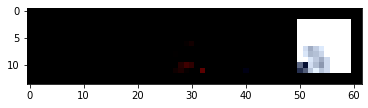

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


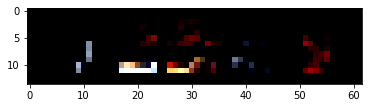

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


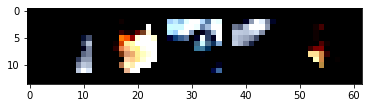

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


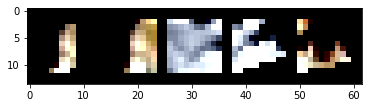

In [ ]:
# Get selected dataset

unsupervised_loader, _, _ = get_cifar10_dataloader()

# Test it
s = iter(unsupervised_loader)
x, y = s.next()

print(x.size())
print(y.size())

for i in range(4):
  imshow(torchvision.utils.make_grid(x[0, i]))

### Train

Epoch 8/20, Epoch Loss: 2.0065

Big loss!!

In [ ]:
# Train the network
print(f"Encoder: {encoder_model}, Crop: {crop}, Grid Size: {grid_size}, Norm: {norm}, Pred Directions: {pred_directions}, Patch Aug: {patch_aug}")

train()

Encoder: vgg16, Crop: 30-2, Grid Size: 5, Norm: , Pred Directions: 1, Patch Aug: 1
Epoch 1/20, Iteration 1/1563, Loss: 2.8332, Time(s): 0.48
Epoch 1/20, Iteration 156/1563, Loss: 2.7122, Time(s): 37.96
Epoch 1/20, Iteration 312/1563, Loss: 2.7051, Time(s): 38.33
Epoch 1/20, Iteration 468/1563, Loss: 2.6184, Time(s): 38.23
Epoch 1/20, Iteration 624/1563, Loss: 2.5434, Time(s): 38.59
Epoch 1/20, Iteration 780/1563, Loss: 2.6237, Time(s): 38.30
Epoch 1/20, Iteration 936/1563, Loss: 2.5820, Time(s): 38.39
Epoch 1/20, Iteration 1092/1563, Loss: 2.6833, Time(s): 38.46
Epoch 1/20, Iteration 1248/1563, Loss: 2.5010, Time(s): 38.70
Epoch 1/20, Iteration 1404/1563, Loss: 2.5542, Time(s): 38.61
Epoch 1/20, Iteration 1560/1563, Loss: 2.5140, Time(s): 43.06
Epoch 1/20, Epoch Loss: 2.5459
Saving..
Epoch 2/20, Iteration 1/1563, Loss: 2.4656, Time(s): 0.40
Epoch 2/20, Iteration 156/1563, Loss: 2.3960, Time(s): 39.68
Epoch 2/20, Iteration 312/1563, Loss: 2.4626, Time(s): 37.72
Epoch 2/20, Iteration 468

## Supervised

### Config


In [ ]:
checkpoint_dir = './drive/MyDrive/ADL/3_3/vgg_checkpoint_exemplar/'
encoder_model = 'vgg16'
augment_mode = 'exemplar'
train_size = 10000 
batch_size = 100

fully_supervised = 0 #WTF is it gonna be man
cpc_patch_aug = 1 
patch_aug = 0
lr = 0.1 
lr_gamma = 0.1 #Scheduler

### Load data

Training: Compose(
    RandomCrop(size=(30, 30), padding=2)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=[0.49139968, 0.48215827, 0.44653124], std=[0.24703233, 0.24348505, 0.26158768])
    Patchify(grid_size=5)
)
Testing: Compose(
    CenterCrop(size=(30, 30))
    ToTensor()
    Normalize(mean=[0.49139968, 0.48215827, 0.44653124], std=[0.24703233, 0.24348505, 0.26158768])
    Patchify(grid_size=5)
)
Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([100, 5, 5, 3, 10, 10])
torch.Size([100])


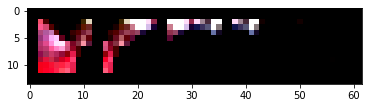

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


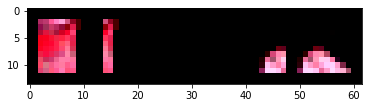

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


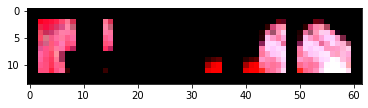

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


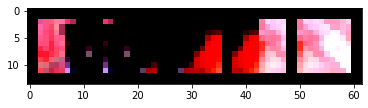

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([100, 5, 5, 3, 10, 10])
torch.Size([100])


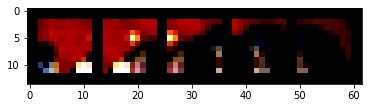

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


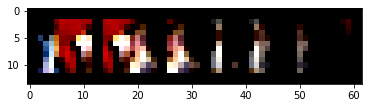

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


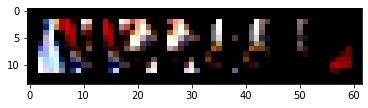

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


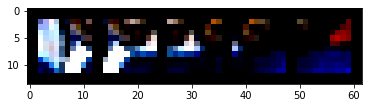

In [ ]:
_, train_loader, test_loader = get_cifar10_dataloader()

# Test it

s = iter(train_loader)

x, y = s.next()
print(x.size())
print(y.size())
for i in range(4):
  imshow(torchvision.utils.make_grid(x[0, i]))

# Test it
s = iter(test_loader)
x, y = s.next()
print(x.size())
print(y.size())
for i in range(4):
  imshow(torchvision.utils.make_grid(x[0, i]))


### Train

Best Accuracy: 47.24 - epoch 20

worse than ResNet18

In [ ]:

print("Training CPC Classifier")

# Load the CPC trained encoder (with classifier layer activated)
if encoder_model == "resnet18":
    net = ResNet18(BasicBlock, [2, 2, 2, 2], use_classifier=True)
elif encoder_model == "vgg16":
    net = VGG16(use_classifier=True)
net = net.to('cuda')

# Load from checkpoint
print('==> Resuming from checkpoint..')
checkpoint = torch.load(checkpoint_dir + 'ckpt.pth')
# Remove "enc" prefix in model keys()
checkpoint['model'] = {k[4:]: v for k, v in checkpoint['model'].items() if 'enc' in k}
net.load_state_dict(checkpoint['model'])
loss = checkpoint['loss']
epoch = checkpoint['epoch'] 
print('recovered loss and epoch:')
print(loss)
print(epoch)


# Freeze encoder layers
for name, param in net.named_parameters():
    if ("classifier" not in name) and ("linear" not in name):
        param.requires_grad = False
    else:
        param.requires_grad = True

optimizer = optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=lr)


# define scheduler based on argument inputs
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=lr_gamma)

loss_function = nn.CrossEntropyLoss()

try:
    train_classifier()
except KeyboardInterrupt:
    print("\nEnding Program on Keyboard Interrupt")


Training CPC Classifier
==> Resuming from checkpoint..


  0%|          | 0/100 [00:00<?, ?it/s]

recovered loss and epoch:
2.0064739768321695
8


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1/20 (lr=0.1)
Train: 1.7488, 35.16%
Test:  1.5832, 40.74%


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 2/20 (lr=0.1)
Train: 1.5750, 40.81%
Test:  1.5290, 43.16%


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 3/20 (lr=0.1)
Train: 1.5460, 41.93%
Test:  1.5200, 42.05%


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 4/20 (lr=0.1)
Train: 1.5240, 42.95%
Test:  1.4902, 43.74%


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 5/20 (lr=0.1)
Train: 1.5033, 43.79%
Test:  1.4779, 44.23%


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 6/20 (lr=0.1)
Train: 1.5008, 43.81%
Test:  1.4756, 44.74%


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 7/20 (lr=0.1)
Train: 1.4894, 44.31%
Test:  1.4772, 44.83%


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 8/20 (lr=0.1)
Train: 1.4799, 45.21%
Test:  1.4762, 43.79%


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 9/20 (lr=0.1)
Train: 1.4794, 44.99%
Test:  1.4555, 44.93%


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 10/20 (lr=0.1)
Train: 1.4706, 44.95%
Test:  1.4449, 46.22%


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 11/20 (lr=0.1)
Train: 1.4652, 45.50%
Test:  1.4429, 45.77%


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 12/20 (lr=0.1)
Train: 1.4561, 46.24%
Test:  1.4459, 44.96%


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 13/20 (lr=0.1)
Train: 1.4458, 46.50%
Test:  1.4397, 46.15%


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 14/20 (lr=0.1)
Train: 1.4481, 46.21%
Test:  1.4276, 46.98%


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 15/20 (lr=0.1)
Train: 1.4516, 46.03%
Test:  1.4315, 46.74%


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 16/20 (lr=0.1)
Train: 1.4452, 46.21%
Test:  1.4289, 46.19%


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 17/20 (lr=0.1)
Train: 1.4426, 46.38%
Test:  1.4258, 46.49%


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 18/20 (lr=0.1)
Train: 1.4333, 46.54%
Test:  1.4307, 46.17%


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 19/20 (lr=0.1)
Train: 1.4299, 47.22%
Test:  1.4309, 46.36%


100%|██████████| 100/100 [00:08<00:00, 12.11it/s]

Epoch: 20/20 (lr=0.1)
Train: 1.4293, 46.76%
Test:  1.4142, 47.24%
Best Accuracy: 47.24 - epoch 20


# VGG16 Rotate

## Self-Supervised

### Config

augment_mode = rotate

encoder_model = vgg16

In [ ]:
checkpoint_dir = './drive/MyDrive/ADL/3_3/vgg_checkpoint_rotate/'
augment_mode = 'rotate'
encoder_model = "vgg16"
trained_epochs = 0

train_size = None
fully_supervised = 0 
patch_aug = 1

batch_size = 32 
lr = 2e-4

### Model

In [ ]:

# Define Encoder Network
if encoder_model == "resnet18":
  enc = ResNet18(BasicBlock, [2, 2, 2, 2], use_classifier=False)
elif encoder_model == "vgg16":
  enc = VGG16(use_classifier=False)
    
# Define Autrogressive Network
ar = PixelCNN(in_channels=enc.encoding_size)

# Define CPC Network
net = CPC(enc, ar, pred_directions, pred_steps, neg_samples)
net = net.to('cuda')


# Freeze classifier layer - save memory
for name, param in net.named_parameters():
    if ("linear" in name) or ('classifier' in name):
        param.requires_grad = False

optimizer = optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=lr)

if trained_epochs != 0: # Load from checkpoint
  load_from_checkpoint()
  net.train()

### Load data

Training: Compose(
    RandomCrop(size=(30, 30), padding=2)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    PatchifyAugment(grid_size=5, gray=0)
    PatchAugNormalize(mean=[0.49139968, 0.48215827, 0.44653124], std=[0.24703233, 0.24348505, 0.26158768])
)
Testing: Compose(
    CenterCrop(size=(30, 30))
    ToTensor()
    Normalize(mean=[0.49139968, 0.48215827, 0.44653124], std=[0.24703233, 0.24348505, 0.26158768])
    Patchify(grid_size=5)
)
Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 5, 5, 3, 10, 10])
torch.Size([32])


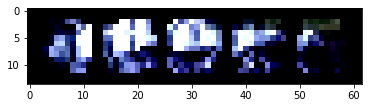

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


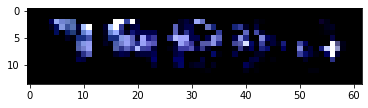

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


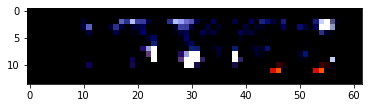

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


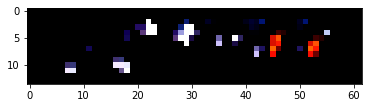

In [ ]:
# Get selected dataset

unsupervised_loader, _, _ = get_cifar10_dataloader()

# Test it
s = iter(unsupervised_loader)
x, y = s.next()

print(x.size())
print(y.size())

for i in range(4):
  imshow(torchvision.utils.make_grid(x[0, i]))

### Train

Epoch 15/20, Epoch Loss: 0.9239

In [ ]:
# Train the network
print(f"Encoder: {encoder_model}, Crop: {crop}, Grid Size: {grid_size}, Norm: {norm}, Pred Directions: {pred_directions}, Patch Aug: {patch_aug}")

train()

Encoder: vgg16, Crop: 30-2, Grid Size: 5, Norm: , Pred Directions: 1, Patch Aug: 1
Epoch 1/20, Iteration 1/1563, Loss: 2.8332, Time(s): 0.25
Epoch 1/20, Iteration 156/1563, Loss: 2.3602, Time(s): 23.75
Epoch 1/20, Iteration 312/1563, Loss: 2.3222, Time(s): 22.54
Epoch 1/20, Iteration 468/1563, Loss: 2.3093, Time(s): 22.07
Epoch 1/20, Iteration 624/1563, Loss: 2.0648, Time(s): 21.71
Epoch 1/20, Iteration 780/1563, Loss: 2.0609, Time(s): 21.88
Epoch 1/20, Iteration 936/1563, Loss: 1.8643, Time(s): 24.01
Epoch 1/20, Iteration 1092/1563, Loss: 2.0911, Time(s): 22.16
Epoch 1/20, Iteration 1248/1563, Loss: 1.8216, Time(s): 22.15
Epoch 1/20, Iteration 1404/1563, Loss: 1.7214, Time(s): 22.09
Epoch 1/20, Iteration 1560/1563, Loss: 1.9135, Time(s): 24.81
Epoch 1/20, Epoch Loss: 1.8606
Saving..
Epoch 2/20, Iteration 1/1563, Loss: 1.7839, Time(s): 0.26
Epoch 2/20, Iteration 156/1563, Loss: 1.5587, Time(s): 21.95
Epoch 2/20, Iteration 312/1563, Loss: 1.6553, Time(s): 23.75
Epoch 2/20, Iteration 468

## Supervised

### Config

In [ ]:
checkpoint_dir = './drive/MyDrive/ADL/3_3/vgg_checkpoint_rotate/'
encoder_model = 'vgg16'
augment_mode = 'rotate'
train_size = 10000 
batch_size = 100

fully_supervised = 0 #WTF is it gonna be man
cpc_patch_aug = 1 
patch_aug = 0
lr = 0.1 
lr_gamma = 0.1 #Scheduler

### Load data

Training: Compose(
    RandomCrop(size=(30, 30), padding=2)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=[0.49139968, 0.48215827, 0.44653124], std=[0.24703233, 0.24348505, 0.26158768])
    Patchify(grid_size=5)
)
Testing: Compose(
    CenterCrop(size=(30, 30))
    ToTensor()
    Normalize(mean=[0.49139968, 0.48215827, 0.44653124], std=[0.24703233, 0.24348505, 0.26158768])
    Patchify(grid_size=5)
)
Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([100, 5, 5, 3, 10, 10])
torch.Size([100])


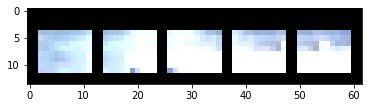

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


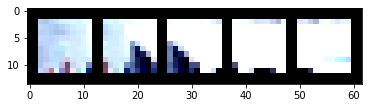

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


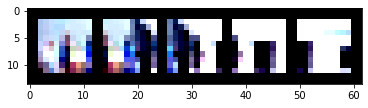

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


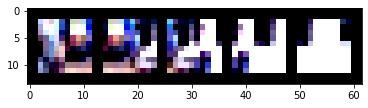

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([100, 5, 5, 3, 10, 10])
torch.Size([100])


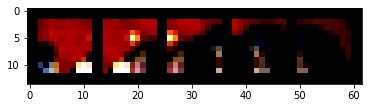

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


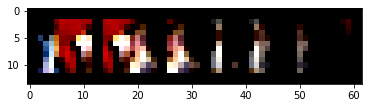

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


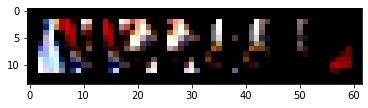

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


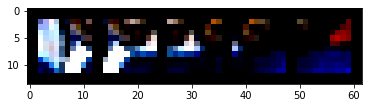

In [ ]:
_, train_loader, test_loader = get_cifar10_dataloader()

# Test it

s = iter(train_loader)

x, y = s.next()
print(x.size())
print(y.size())
for i in range(4):
  imshow(torchvision.utils.make_grid(x[0, i]))

# Test it
s = iter(test_loader)
x, y = s.next()
print(x.size())
print(y.size())
for i in range(4):
  imshow(torchvision.utils.make_grid(x[0, i]))


### Train

Best Accuracy: 44.93 - epoch 15

Ok. I saw it coming

In [ ]:

print("Training CPC Classifier")

# Load the CPC trained encoder (with classifier layer activated)
if encoder_model == "resnet18":
    net = ResNet18(BasicBlock, [2, 2, 2, 2], use_classifier=True)
elif encoder_model == "vgg16":
    net = VGG16(use_classifier=True)
net = net.to('cuda')

# Load from checkpoint
print('==> Resuming from checkpoint..')
checkpoint = torch.load(checkpoint_dir + 'ckpt.pth')
# Remove "enc" prefix in model keys()
checkpoint['model'] = {k[4:]: v for k, v in checkpoint['model'].items() if 'enc' in k}
net.load_state_dict(checkpoint['model'])
loss = checkpoint['loss']
epoch = checkpoint['epoch'] 
print('recovered loss and epoch:')
print(loss)
print(epoch)


# Freeze encoder layers
for name, param in net.named_parameters():
    if ("classifier" not in name) and ("linear" not in name):
        param.requires_grad = False
    else:
        param.requires_grad = True

optimizer = optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=lr)


# define scheduler based on argument inputs
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=lr_gamma)

loss_function = nn.CrossEntropyLoss()

try:
    train_classifier()
except KeyboardInterrupt:
    print("\nEnding Program on Keyboard Interrupt")


Training CPC Classifier
==> Resuming from checkpoint..


  0%|          | 0/100 [00:00<?, ?it/s]

recovered loss and epoch:
0.923943545955878
15


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1/20 (lr=0.1)
Train: 1.8244, 32.45%
Test:  1.6949, 38.13%


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 2/20 (lr=0.1)
Train: 1.6766, 39.03%
Test:  1.6340, 40.12%


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 3/20 (lr=0.1)
Train: 1.6230, 40.24%
Test:  1.6125, 40.59%


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 4/20 (lr=0.1)
Train: 1.6036, 41.16%
Test:  1.6138, 41.40%


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 5/20 (lr=0.1)
Train: 1.5841, 41.74%
Test:  1.5873, 42.20%


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 6/20 (lr=0.1)
Train: 1.5705, 41.88%
Test:  1.5717, 43.12%


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 7/20 (lr=0.1)
Train: 1.5607, 42.73%
Test:  1.5539, 43.00%


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 8/20 (lr=0.1)
Train: 1.5455, 43.56%
Test:  1.5625, 42.80%


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 9/20 (lr=0.1)
Train: 1.5434, 43.30%
Test:  1.5445, 43.73%


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 10/20 (lr=0.1)
Train: 1.5331, 43.78%
Test:  1.5571, 43.19%


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 11/20 (lr=0.1)
Train: 1.5335, 43.50%
Test:  1.5398, 43.69%


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 12/20 (lr=0.1)
Train: 1.5206, 44.85%
Test:  1.5498, 43.13%


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 13/20 (lr=0.1)
Train: 1.5173, 44.69%
Test:  1.5492, 43.20%


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 14/20 (lr=0.1)
Train: 1.5042, 45.65%
Test:  1.5411, 43.88%


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 15/20 (lr=0.1)
Train: 1.5027, 45.00%
Test:  1.5176, 44.93%


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 16/20 (lr=0.1)
Train: 1.5051, 44.90%
Test:  1.5455, 43.76%


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 17/20 (lr=0.1)
Train: 1.4967, 45.61%
Test:  1.5173, 44.47%


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 18/20 (lr=0.1)
Train: 1.4999, 45.39%
Test:  1.5557, 43.31%


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 19/20 (lr=0.1)
Train: 1.4995, 45.07%
Test:  1.5368, 43.64%


100%|██████████| 100/100 [00:08<00:00, 12.08it/s]

Epoch: 20/20 (lr=0.1)
Train: 1.4947, 45.51%
Test:  1.5332, 44.15%
Best Accuracy: 44.93 - epoch 15
